## Issue with original Dataset
1. The problem with raw exchange rates (dollar_ex)  
Exchange rates are on wildly different scales:
- 1 USD ≈ 0.9 EUR
- 1 USD ≈ 150 JPY
- 1 USD ≈ 15,000 IDR (Indonesian rupiah)  

2. High Dimensional Data
- Single-country/year effects were dominating the predictions
  
When we tried to model them directly:
- Regression error is dominated by the “big-number” currencies (like rupiah, lira, peso during hyperinflation).
- Predictions can even go negative because the model is trying to fit values across multiple orders of magnitude with one set of coefficients.


## Updates

**TLDR: Normalized the index so that different currencies are measured on the same scale (relative misvaluation), making regression stable, interpretable, and comparable across countries.**

**Used ridge in the pipeline making the regression more robust, especially given the high dimensional data. It reduces overfitting, controls variance, and gives more reliable predictions than plain LinearRegression.**
  
  
### Details  
Using the "adj_price" column as a feature and picking USD as the normalized comparison solves this problem by converting exchange rates into relative misvaluation measures:
- USD = % misvaluation of the local currency vs USD, based on Purchasing Power Parity (PPP).

Example: USD = –0.30, currency is 30% undervalued.
- USD = +0.20, currency is 20% overvalued.
- This turns “apples vs oranges” into apples vs apples. Every country’s currency is now measured on the same normalized scale: percent deviation from PPP.

Added ridge to the pipeline so single-country/year effects don't dominate the predictions.  

Why we needed to make this change  

- Comparability: Instead of fitting numbers ranging from 0.6 (GBP) to 15,000 (IDR), you’re fitting values between about –1.5 and +1.5.
- Stability: RMSE and MAE are meaningful across countries.
- Interpretability: A coefficient that predicts USD misvaluation can be directly interpreted as “on average, X% over- or undervalued.”

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

DATA_PATH = "big-mac-adjusted-index.csv"
TARGET = "USD"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (1593, 14)
Columns: ['date', 'iso_a3', 'currency_code', 'name', 'local_price', 'dollar_ex', 'dollar_price', 'GDP_bigmac', 'adj_price', 'USD', 'EUR', 'GBP', 'JPY', 'CNY']


,date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,GDP_bigmac,adj_price,USD,EUR,GBP,JPY,CNY
0,2000-04-01,ARG,ARS,Argentina,2.50,1.000000,2.500000,7803.328512,1.927633,0.39805,0.16574,-0.06353,0.10595,0.96855
1,2000-04-01,AUS,AUD,Australia,2.59,1.680000,1.541667,29189.447784,2.317830,-0.28301,-0.40215,-0.51973,-0.43281,0.00958
2,2000-04-01,BRA,BRL,Brazil,2.95,1.790000,1.648045,4913.910780,1.874915,-0.05247,-0.20992,-0.36530,-0.25044,0.33419
3,2000-04-01,GBR,GBP,Britain,1.90,0.632911,3.002000,20958.600084,2.167656,0.49289,0.24482,0.00000,0.18097,1.10209
4,2000-04-01,CAN,CAD,Canada,2.85,1.470000,1.938776,26087.329235,2.261231,-0.07575,-0.22933,-0.38090,-0.26886,0.30141


In [4]:
# Parse date
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Basic audit of missingness for relevant columns
cols_of_interest = ["date", "name", "local_price", "dollar_ex", "dollar_price", "GDP_bigmac", "adj_price", TARGET]
print("Missing values:\n", df[cols_of_interest].isna().sum().sort_values(ascending=False))

# Drop rows where we lack essential fields
essential = ["name", "date", "adj_price", "GDP_bigmac", TARGET]
df = df.dropna(subset=essential).copy()

# We'll include both country and YEAR fixed effects.
df["Year"] = df["date"].dt.year

print("\nAfter cleaning:")
print("Shape:", df.shape)
df[["name", "Year", "adj_price", "GDP_bigmac", TARGET]].head()


Missing values:
 date            0
name            0
local_price     0
dollar_ex       0
dollar_price    0
GDP_bigmac      0
adj_price       0
USD             0
dtype: int64

After cleaning:
Shape: (1593, 15)


,name,Year,adj_price,GDP_bigmac,USD
0,Argentina,2000,1.927633,7803.328512,0.39805
1,Australia,2000,2.317830,29189.447784,-0.28301
2,Brazil,2000,1.874915,4913.910780,-0.05247
3,Britain,2000,2.167656,20958.600084,0.49289
4,Canada,2000,2.261231,26087.329235,-0.07575


In [5]:
# Data sanity check — making sure the target is on a reasonable scale and identifying which
# numeric predictors are most aligned with it, before fitting models.

print("Target (USD) summary statistics:")
print(df[TARGET].describe())

print("\nCorrelations with target (numeric cols):")
num_cols = ["adj_price", "GDP_bigmac", "dollar_price", "local_price", "dollar_ex"]
num_cols = [c for c in num_cols if c in df.columns]
print(df[num_cols + [TARGET]].corr()[TARGET].sort_values(ascending=False))


Target (USD) summary statistics:
count    1593.000000
mean        0.038624
std         0.346861
min        -0.747190
25%        -0.186030
50%        -0.006930
75%         0.199280
max         1.925850
Name: USD, dtype: float64

Correlations with target (numeric cols):
USD             1.000000
dollar_price    0.625154
local_price     0.070990
dollar_ex       0.068318
GDP_bigmac     -0.067667
adj_price      -0.143349
Name: USD, dtype: float64


In [6]:
# Features: normalized & macro signals + fixed effects
numeric_features = ["adj_price", "GDP_bigmac"]
categorical_features = ["name", "Year"]

X = df[numeric_features + categorical_features].copy()
y = df[TARGET].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Column transformer: one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ]
)


In [7]:
# Standard lin regression model
linreg = Pipeline(steps=[
    ("prep", preprocessor),
    ("reg", LinearRegression())
])
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = float(np.sqrt(mean_squared_error(y_test, y_pred_lin)))
mae_lin = float(mean_absolute_error(y_test, y_pred_lin))

print(f"LinearRegression: R^2={r2_lin:.4f}  RMSE={rmse_lin:.4f}  MAE={mae_lin:.4f}")


LinearRegression: R^2=0.6667  RMSE=0.2247  MAE=0.1555


In [8]:
# Ridge lin regression model to handle high demonsial data
ridge = Pipeline(steps=[
    ("prep", preprocessor),
    ("reg", Ridge(alpha=1.0, random_state=42))
])
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = float(np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
mae_ridge = float(mean_absolute_error(y_test, y_pred_ridge))

print(f"Ridge(alpha=1.0) -> R^2={r2_ridge:.4f}  RMSE={rmse_ridge:.4f}  MAE={mae_ridge:.4f}")

# CV-tune alpha
alphas = np.logspace(-2, 2, 15)
ridgecv = Pipeline(steps=[
    ("prep", preprocessor),
    ("reg", RidgeCV(alphas=alphas, store_cv_values=False))
])
ridgecv.fit(X_train, y_train)
y_pred_ridgecv = ridgecv.predict(X_test)

r2_ridgecv = r2_score(y_test, y_pred_ridgecv)
rmse_ridgecv = float(np.sqrt(mean_squared_error(y_test, y_pred_ridgecv)))
mae_ridgecv = float(mean_absolute_error(y_test, y_pred_ridgecv))

best_alpha = ridgecv.named_steps["reg"].alpha_
print(f"RidgeCV(alpha={best_alpha:.4f}) -> R^2={r2_ridgecv:.4f}  RMSE={rmse_ridgecv:.4f}  MAE={mae_ridgecv:.4f}")


Ridge(alpha=1.0) -> R^2=-0.0095  RMSE=0.3910  MAE=0.2820
RidgeCV(alpha=0.0373) -> R^2=0.7348  RMSE=0.2004  MAE=0.1394


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


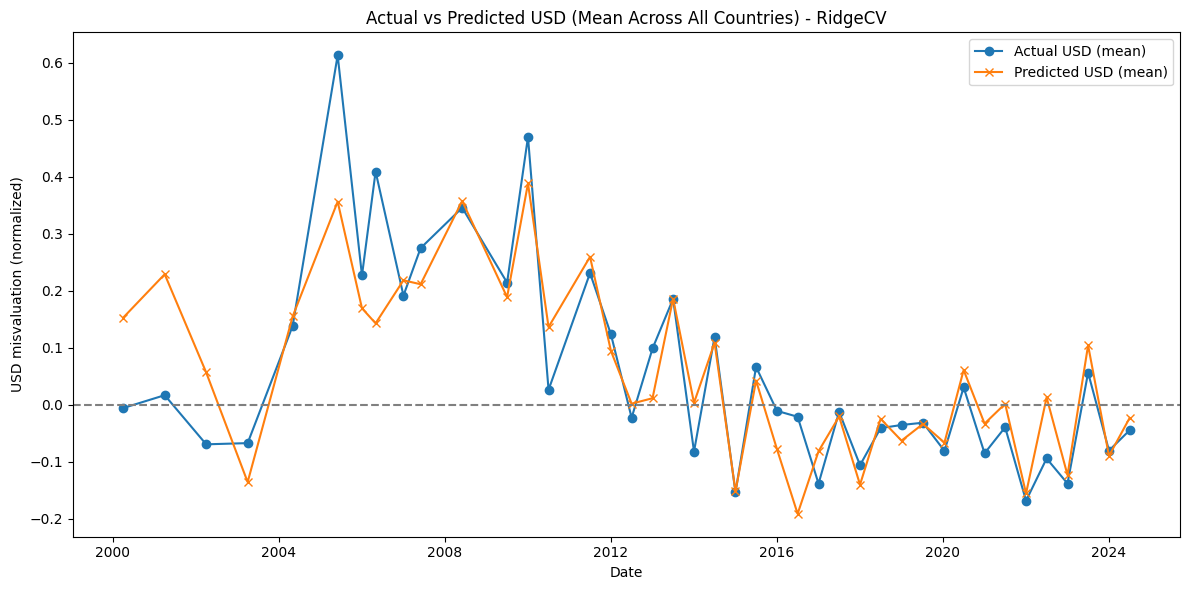

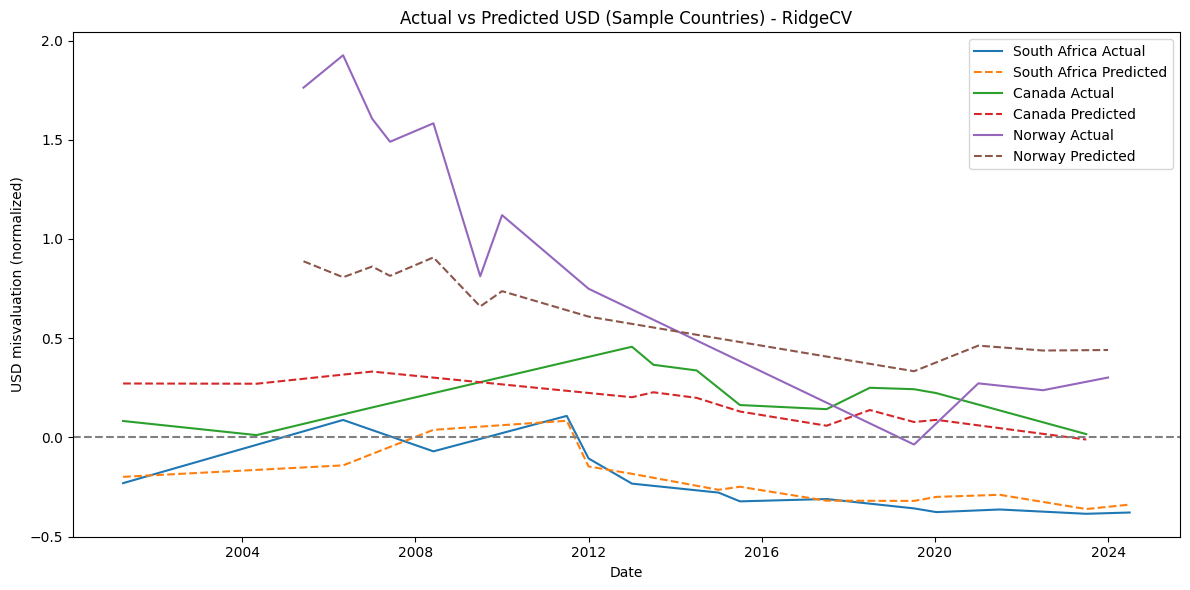

In [9]:
# --- Time series: Actual vs Predicted USD ---

# Build DataFrame with test set results
ts_df = pd.DataFrame({
    "Date": df.loc[y_test.index, "date"].values,
    "Country": X.loc[y_test.index, "name"].values,
    "Actual": y_test.values,
    "Predicted": y_pred_ridgecv
}).sort_values("Date")

# 1) Overall average across all countries (by date)
avg_by_date = ts_df.groupby("Date")[["Actual", "Predicted"]].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(avg_by_date["Date"], avg_by_date["Actual"], label="Actual USD (mean)", marker="o")
plt.plot(avg_by_date["Date"], avg_by_date["Predicted"], label="Predicted USD (mean)", marker="x")
plt.title("Actual vs Predicted USD (Mean Across All Countries) - RidgeCV")
plt.xlabel("Date")
plt.ylabel("USD misvaluation (normalized)")
plt.axhline(0, linestyle="--", color="grey")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Country-level examples (pick top 3 most common countries in test set)
top_countries = ts_df["Country"].value_counts().head(3).index.tolist()

plt.figure(figsize=(12,6))
for c in top_countries:
    subset = ts_df[ts_df["Country"] == c].sort_values("Date")
    plt.plot(subset["Date"], subset["Actual"], label=f"{c} Actual", linestyle="-")
    plt.plot(subset["Date"], subset["Predicted"], label=f"{c} Predicted", linestyle="--")
plt.title("Actual vs Predicted USD (Sample Countries) - RidgeCV")
plt.xlabel("Date")
plt.ylabel("USD misvaluation (normalized)")
plt.axhline(0, linestyle="--", color="grey")
plt.legend()
plt.tight_layout()
plt.show()


Top 12 by |mean residual| — LinearRegression:

                mean_residual
Country                      
Norway               0.428061
Uruguay              0.415528
Denmark              0.364819
Azerbaijan          -0.240998
Ukraine             -0.178157
Argentina            0.155481
Sweden              -0.150412
Oman                -0.135352
Czech Republic      -0.133850
Qatar               -0.130336
Brazil              -0.126577
Peru                 0.105404

Top 12 by |mean residual| — RidgeCV:

                mean_residual
Country                      
Denmark              0.323831
Norway               0.322276
Costa Rica          -0.158970
Sri Lanka           -0.155093
Sweden              -0.152499
Argentina            0.126758
Peru                 0.121814
Czech Republic      -0.112167
Azerbaijan          -0.104740
Saudi Arabia        -0.097477
New Zealand         -0.094337
Romania              0.091618


/tmp/ipython-input-3814268793.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top_lin, vert=True, showfliers=False)


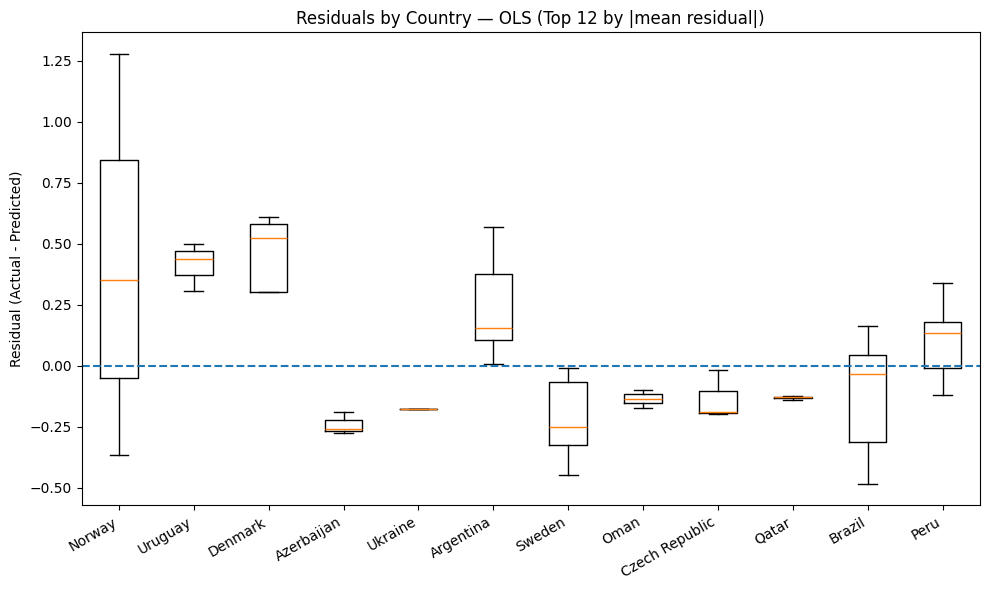

/tmp/ipython-input-3814268793.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top_ridge, vert=True, showfliers=False)


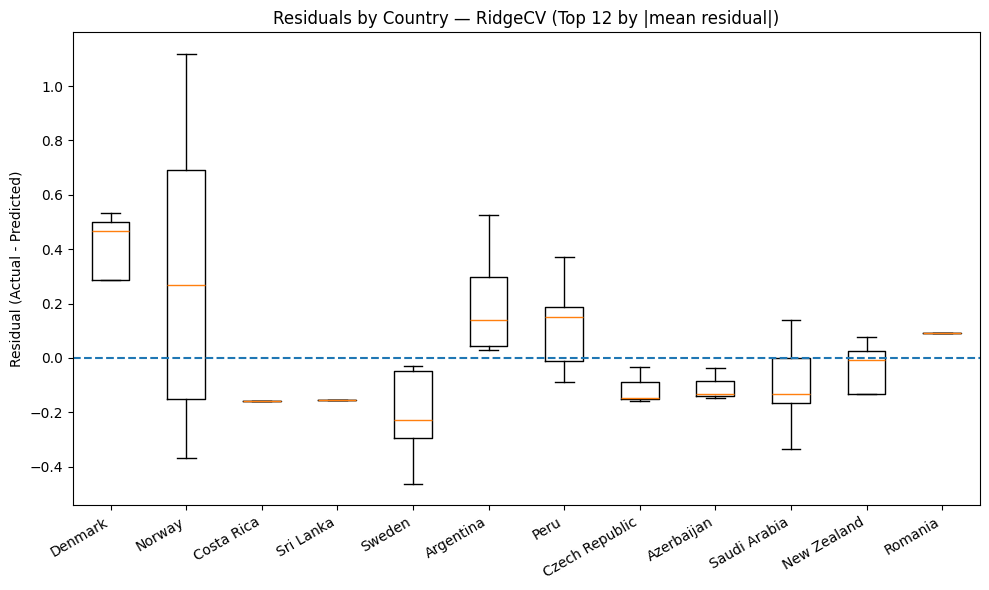

In [18]:
def residual_df(y_true, y_pred, X_design, country_col="name"):
    res = y_true.values - y_pred
    idx = y_true.index
    countries = X_design.loc[idx, country_col].values
    return pd.DataFrame({"Country": countries, "Residual": res})

# Build residual frames
res_lin  = residual_df(y_test, y_pred_lin,     X, country_col="name")
res_ridge= residual_df(y_test, y_pred_ridgecv, X, country_col="name")

def rank_country_bias(res_df, k=12):
    bias = (res_df.groupby("Country")["Residual"].mean()
            .to_frame("mean_residual")
            .assign(abs_mean=lambda d: d["mean_residual"].abs())
            .sort_values("abs_mean", ascending=False))
    return bias.head(k)

print("Top 12 by |mean residual| — LinearRegression:\n")
bias_lin = rank_country_bias(res_lin, 12)
print(bias_lin[["mean_residual"]])

print("\nTop 12 by |mean residual| — RidgeCV:\n")
bias_ridge = rank_country_bias(res_ridge, 12)
print(bias_ridge[["mean_residual"]])

# Boxplots for LinearRegression
plt.figure(figsize=(10,6))
top_lin = bias_lin.index.tolist()
sub_lin = res_lin[res_lin["Country"].isin(top_lin)]
data = [sub_lin.loc[sub_lin["Country"] == c, "Residual"].values for c in top_lin]
plt.boxplot(data, labels=top_lin, vert=True, showfliers=False)
plt.axhline(0, linestyle="--")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals by Country — OLS (Top 12 by |mean residual|)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# Boxplots for RidgeCV
plt.figure(figsize=(10,6))
top_ridge = bias_ridge.index.tolist()
sub_r = res_ridge[res_ridge["Country"].isin(top_ridge)]
data = [sub_r.loc[sub_r["Country"] == c, "Residual"].values for c in top_ridge]
plt.boxplot(data, labels=top_ridge, vert=True, showfliers=False)
plt.axhline(0, linestyle="--")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals by Country — RidgeCV (Top 12 by |mean residual|)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


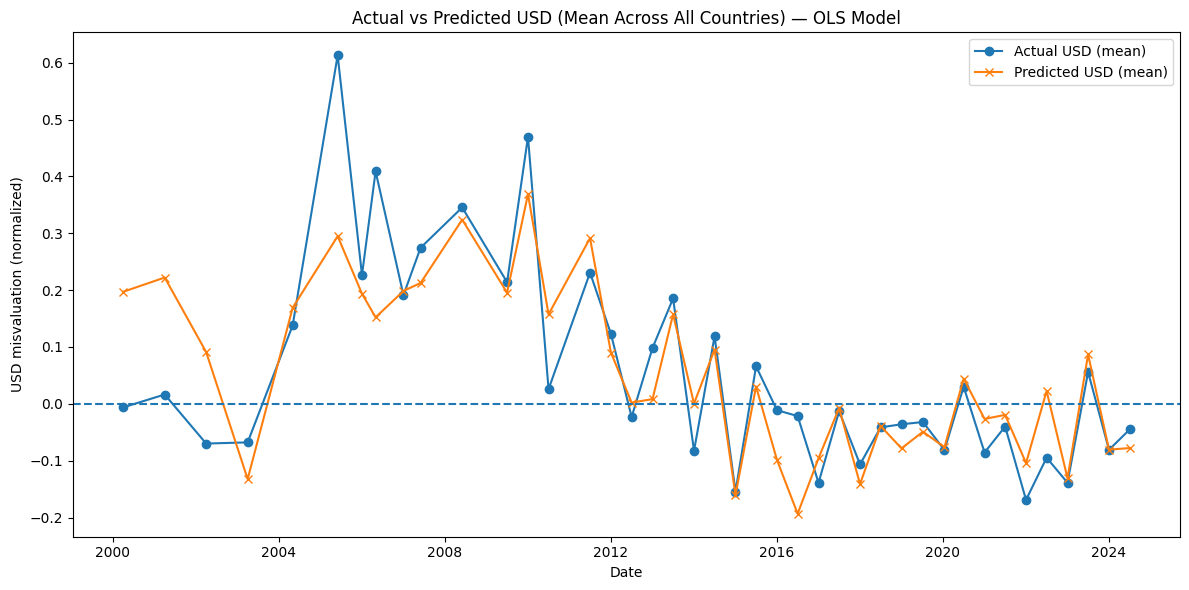

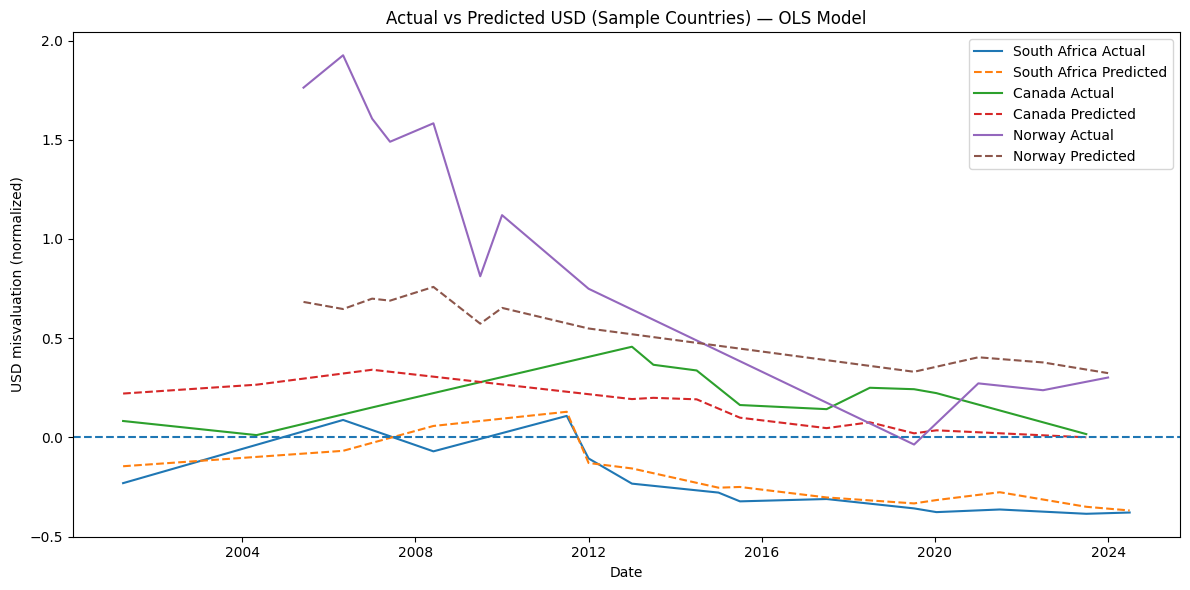

In [17]:
# --- Actual vs Predicted USD over time (LinearRegression) ---

# Build DataFrame with test set results (uses linreg's predictions)
ts_lin = pd.DataFrame({
    "Date": df.loc[y_test.index, "date"].values,
    "Country": X.loc[y_test.index, "name"].values,
    "Actual": y_test.values,
    "Predicted": y_pred_lin
}).sort_values("Date")

# 1) Overall average across all countries (by date)
avg_by_date_lin = ts_lin.groupby("Date")[["Actual", "Predicted"]].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(avg_by_date_lin["Date"], avg_by_date_lin["Actual"], label="Actual USD (mean)", marker="o")
plt.plot(avg_by_date_lin["Date"], avg_by_date_lin["Predicted"], label="Predicted USD (mean)", marker="x")
plt.title("Actual vs Predicted USD (Mean Across All Countries) — OLS Model")
plt.xlabel("Date")
plt.ylabel("USD misvaluation (normalized)")
plt.axhline(0, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Country-level examples (top 3 by count in test set)
top_countries_lin = ts_lin["Country"].value_counts().head(3).index.tolist()

plt.figure(figsize=(12,6))
for c in top_countries_lin:
    subset = ts_lin[ts_lin["Country"] == c].sort_values("Date")
    plt.plot(subset["Date"], subset["Actual"], label=f"{c} Actual", linestyle="-")
    plt.plot(subset["Date"], subset["Predicted"], label=f"{c} Predicted", linestyle="--")
plt.title("Actual vs Predicted USD (Sample Countries) — OLS Model")
plt.xlabel("Date")
plt.ylabel("USD misvaluation (normalized)")
plt.axhline(0, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()


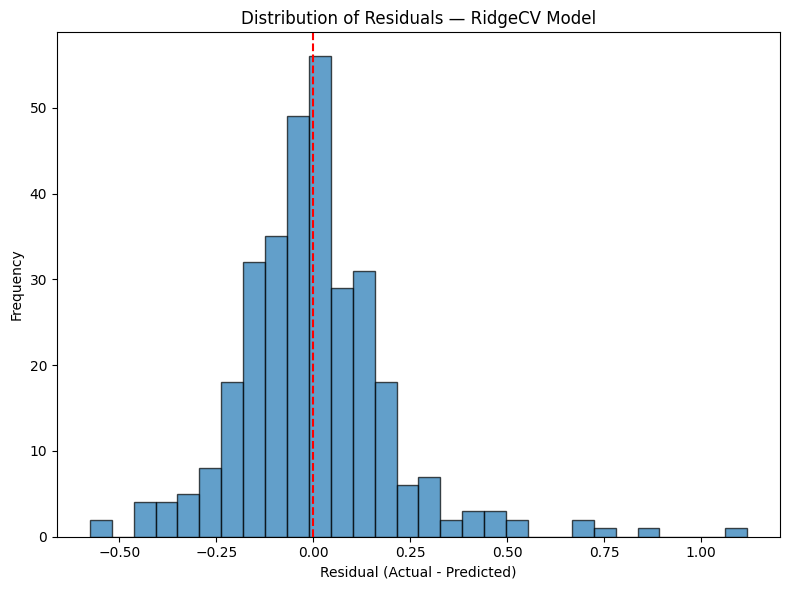

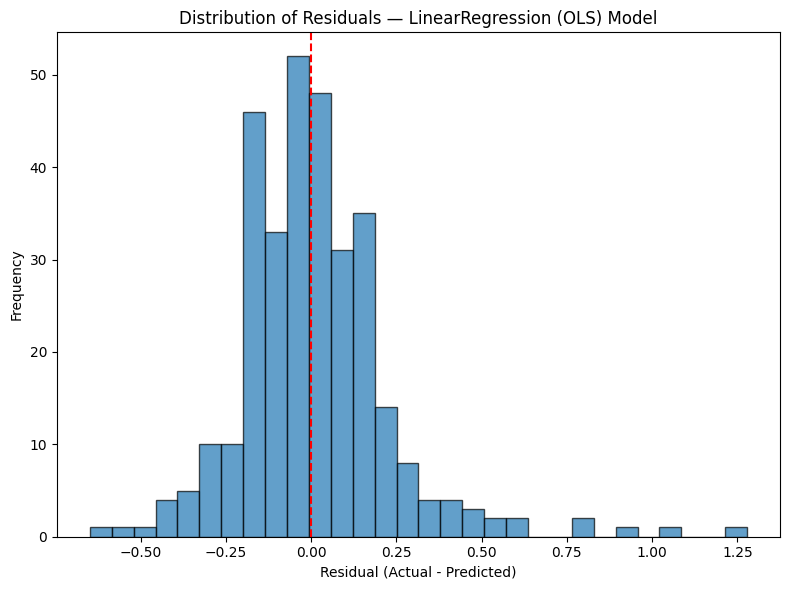

In [13]:
residuals = y_test.values - y_pred_ridgecv

plt.figure(figsize=(8,6))
plt.hist(residuals, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals — RidgeCV Model")
plt.tight_layout()
plt.show()

residuals_lin = y_test.values - y_pred_lin

plt.figure(figsize=(8,6))
plt.hist(residuals_lin, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals — LinearRegression (OLS) Model")
plt.tight_layout()
plt.show()

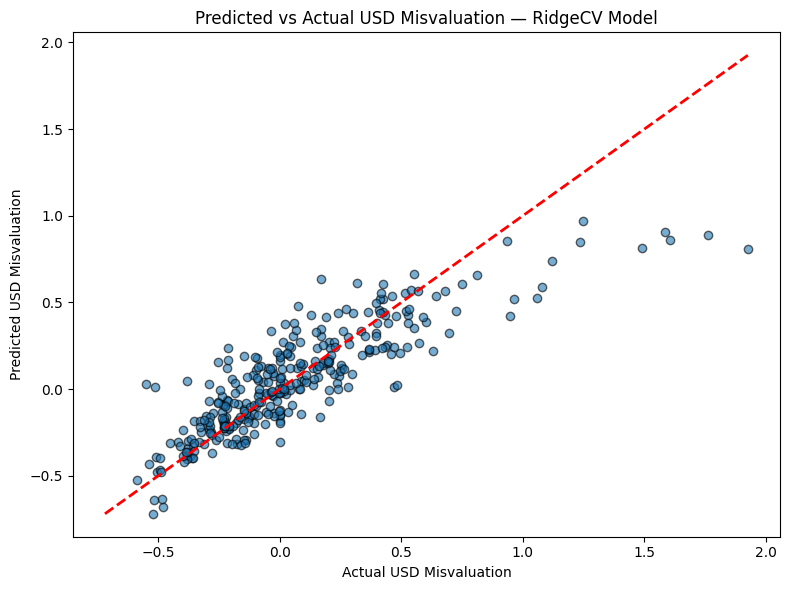

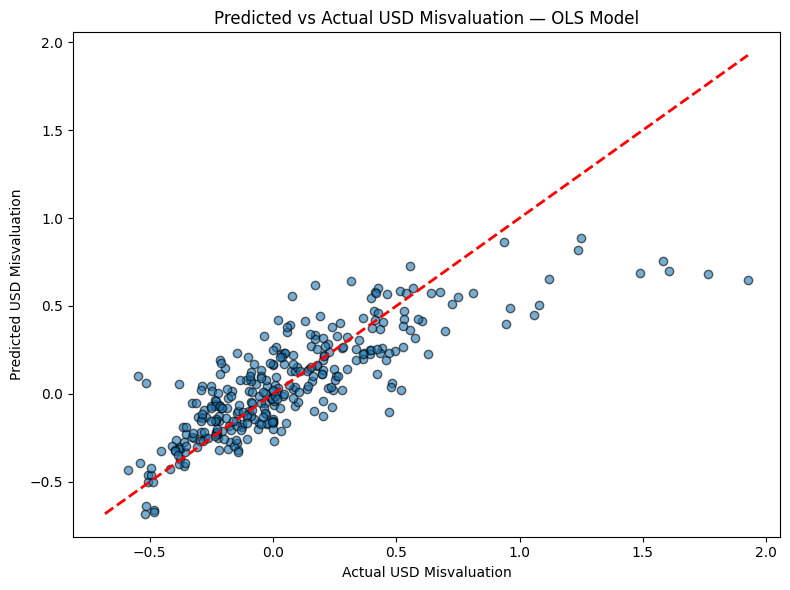

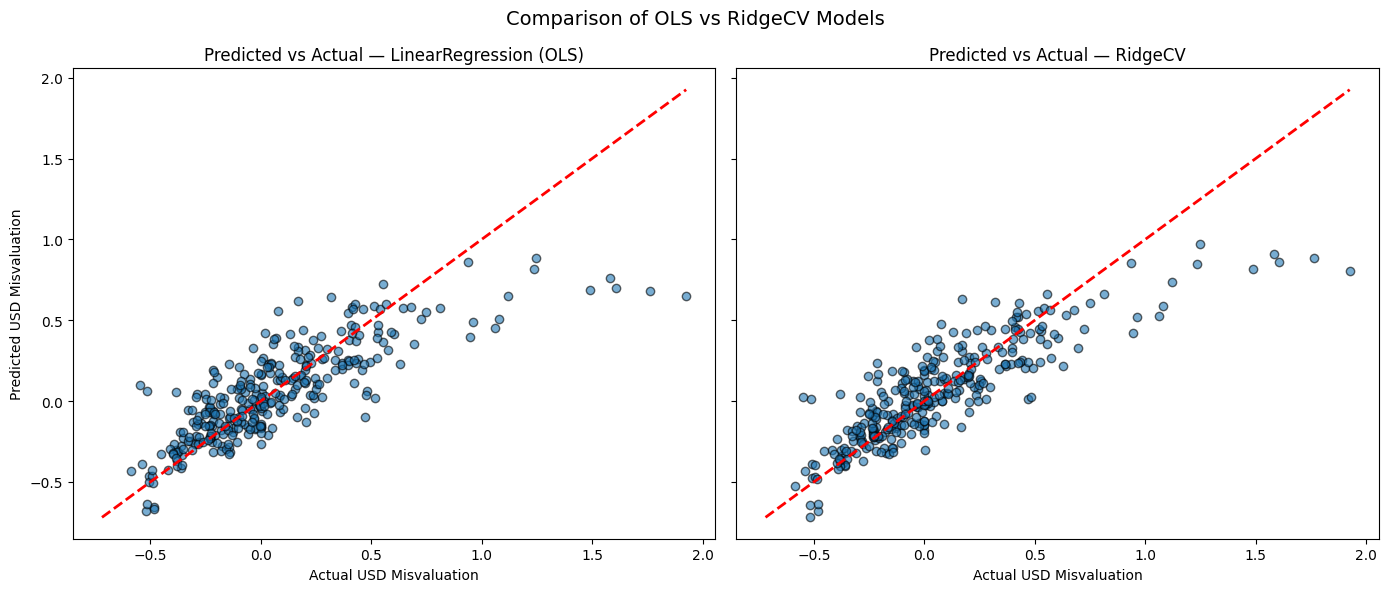

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_ridgecv, alpha=0.6, edgecolor="k")
lims = [min(y_test.min(), y_pred_ridgecv.min()), max(y_test.max(), y_pred_ridgecv.max())]
plt.plot(lims, lims, "r--", linewidth=2)  # 45-degree line
plt.xlabel("Actual USD Misvaluation")
plt.ylabel("Predicted USD Misvaluation")
plt.title("Predicted vs Actual USD Misvaluation — RidgeCV Model")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lin, alpha=0.6, edgecolor="k")
lims = [min(y_test.min(), y_pred_lin.min()), max(y_test.max(), y_pred_lin.max())]
plt.plot(lims, lims, "r--", linewidth=2)  # 45-degree line
plt.xlabel("Actual USD Misvaluation")
plt.ylabel("Predicted USD Misvaluation")
plt.title("Predicted vs Actual USD Misvaluation — OLS Model")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)

# Plot for OLS
axes[0].scatter(y_test, y_pred_lin, alpha=0.6, edgecolor="k")
lims = [min(y_test.min(), y_pred_lin.min(), y_pred_ridgecv.min()),
        max(y_test.max(), y_pred_lin.max(), y_pred_ridgecv.max())]
axes[0].plot(lims, lims, "r--", linewidth=2)
axes[0].set_title("Predicted vs Actual — LinearRegression (OLS)")
axes[0].set_xlabel("Actual USD Misvaluation")
axes[0].set_ylabel("Predicted USD Misvaluation")

# Plot for RidgeCV
axes[1].scatter(y_test, y_pred_ridgecv, alpha=0.6, edgecolor="k")
axes[1].plot(lims, lims, "r--", linewidth=2)
axes[1].set_title("Predicted vs Actual — RidgeCV")
axes[1].set_xlabel("Actual USD Misvaluation")

plt.suptitle("Comparison of OLS vs RidgeCV Models", fontsize=14)
plt.tight_layout()
plt.show()